A2C clean, updated implementation

In [94]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from dataclasses import dataclass, asdict

import plot
from session_tracker import SessionTracker

import modal

In [96]:
def make_env(gym_id):
    def thunk():
        env = gym.make(gym_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)

        return env
    return thunk

In [97]:
class ActorCriticAgent(nn.Module):
    def __init__(self, state_space, action_space, hidden_size=64):
        super(ActorCriticAgent, self).__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.fc1 = nn.Linear(state_space, hidden_size)

        self.actor_head = nn.Linear(hidden_size, action_space)
        self.critic_head = nn.Linear(hidden_size, 1)
    
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        actor_logits = self.actor_head(x)
        critic_value = self.critic_head(x)

        return actor_logits, critic_value
    
    # states (n_envs, n_obs)
    def get_action(self, states):
        # Get the raw output from the network (logits)
        actor_logits, critic_values = self.forward(states)
        
        # Turn logits into probabilities and create a distribution
        # Categorical is useful for discrete action spaces (like Lunar Lander)
        action_distributions = Categorical(logits=actor_logits)
        
        # Sample an action from the distribution
        actions = action_distributions.sample()
        
        # Get the log probability of the chosen action
        log_probs = action_distributions.log_prob(actions)
        log_probs = log_probs.unsqueeze(-1)  # Ensure log_probs has shape (n_envs, 1)
        actions = actions.unsqueeze(-1)  # Ensure actions has shape (n_envs, 1)
        
        # Return the action and its log-probability
        return actions, log_probs, critic_values

In [98]:
@dataclass
class A2CParams:
    gamma: float            = 0.99
    normalize_returns: bool = True
    lr: float               = 0.001
    n_envs: int             = 8
    n_steps: int            = 16

In [99]:
@dataclass
class RolloutData:
    obs: torch.Tensor
    actions: torch.Tensor
    log_probs: torch.Tensor
    values: torch.Tensor
    rewards: torch.Tensor
    dones: torch.Tensor

In [100]:
def collect_data_for_rollout(envs, current_obs, network, n_steps, tracker):
    """
    Collect experiences by running the policy in the environment
    """

    n_envs = envs.num_envs
    n_obs = envs.single_observation_space.shape[0]
    
    rollout_obs_t = torch.zeros((n_envs, n_steps, n_obs)) # (n_envs, n_steps, n_obs)
    rollout_actions_t = torch.zeros((n_envs, n_steps, 1)) # (n_envs, n_steps, 1)
    rollout_log_probs_t = torch.zeros((n_envs, n_steps, 1)) # (n_envs, n_steps, 1)
    rollout_values_t = torch.zeros((n_envs, n_steps, 1)) # (n_envs, n_steps, 1)
    rollout_rewards_t = torch.zeros((n_envs, n_steps, 1)) # (n_envs, n_steps, 1)
    rollout_dones_t = torch.zeros((n_envs, n_steps, 1), dtype=torch.bool) # (n_envs, n_steps, 1)

    for step in range(n_steps):
        obs_t = torch.tensor(current_obs, dtype=torch.float32) # (n_envs, n_obs)
        actions_t, log_probs_t, values_t = network.get_action(obs_t)

        actions = actions_t.squeeze().numpy()  # Convert to numpy for envs.step. t(n_envs, 1) -> np(n_envs)
        next_obs, rewards, terminateds, truncateds, infos = envs.step(actions)
        dones = terminateds | truncateds

        rewards_t = torch.tensor(rewards).float().unsqueeze(-1)  # (n_envs) -> (n_envs, 1)
        dones_t = torch.tensor(dones).unsqueeze(-1)  # (n_envs) -> (n_envs, 1)

        rollout_obs_t[:, step, :] = obs_t
        rollout_actions_t[:, step, :] = actions_t
        rollout_log_probs_t[:, step, :] = log_probs_t
        rollout_values_t[:, step, :] = values_t
        rollout_rewards_t[:, step, :] = rewards_t
        rollout_dones_t[:, step, :] = dones_t

        tracker.increment_timestep(n=envs.num_envs)

        if 'episode' in infos:
            dones = np.array(terminateds | truncateds)
            rewards = np.array(infos['episode']['r'])[dones]
            lengths = np.array(infos['episode']['l'])[dones]
            
            tracker.log_finished_episodes(rewards, lengths)

        # update the obs to the result of the step
        current_obs = next_obs

    rollout_data = RolloutData(
        obs=rollout_obs_t,
        actions=rollout_actions_t,
        log_probs=rollout_log_probs_t,
        values=rollout_values_t,
        rewards=rollout_rewards_t,
        dones=rollout_dones_t
    )
    
    return rollout_data, next_obs

In [103]:
torch.manual_seed(0)
np.random.seed(0)

envs = gym.vector.SyncVectorEnv([make_env('CartPole-v1') for _ in range(8)])

current_obs, _ = envs.reset(seed=0)

network = ActorCriticAgent(
    state_space=envs.single_observation_space.shape[0],
    action_space=envs.single_action_space.n)

tracker = SessionTracker(n_timesteps=100000, print_interval=None, window_length=64)

rollout_data, _ = collect_data_for_rollout(envs, current_obs, network, n_steps=16, tracker=tracker)

rollout_data.log_probs

tensor([[[-0.7903],
         [-0.6137],
         [-0.7918],
         [-0.7790],
         [-0.6386],
         [-0.6140],
         [-0.5981],
         [-0.6031],
         [-0.7901],
         [-0.6035],
         [-0.7876],
         [-0.6036],
         [-0.6083],
         [-0.6024],
         [-0.5902],
         [-0.5726]],

        [[-0.7883],
         [-0.6123],
         [-0.6056],
         [-0.6132],
         [-0.7880],
         [-0.7781],
         [-0.6104],
         [-0.7777],
         [-0.6114],
         [-0.7772],
         [-0.6123],
         [-0.7768],
         [-0.7802],
         [-0.6217],
         [-0.6117],
         [-0.6154]],

        [[-0.6206],
         [-0.7700],
         [-0.7708],
         [-0.6280],
         [-0.7732],
         [-0.7651],
         [-0.6424],
         [-0.7700],
         [-0.6389],
         [-0.7746],
         [-0.7540],
         [-0.6529],
         [-0.6309],
         [-0.6088],
         [-0.7936],
         [-0.7841]],

        [[-0.7722],
         [-0.6

In [104]:
def calculate_returns(rewards, dones, next_obs, network, gamma=0.99, normalize_returns=True):
    all_returns = torch.zeros_like(rewards) # (n_envs, n_steps, 1)

    # bootstrap future returns
    with torch.no_grad():
        next_obs_t = torch.tensor(next_obs)
        _, returns = network(next_obs_t) # (n_envs, 1)

    for t in range(rewards.shape[1] - 1, -1, -1):
        returns *= (1 - dones[:, t, :].float())
        current_rewards = rewards[:, t, :]
        returns = current_rewards + (gamma * returns)
        all_returns[:, t, :] = returns

    if normalize_returns:
        all_returns = (all_returns - all_returns.mean()) / (all_returns.std() + 1e-9)

    return all_returns

In [9]:
envs = gym.vector.SyncVectorEnv([make_env('CartPole-v1') for _ in range(2)])

current_obs, _ = envs.reset()

network = ActorCriticAgent(
    state_space=envs.single_observation_space.shape[0],
    action_space=envs.single_action_space.n)

tracker = SessionTracker(n_timesteps=100000, print_interval=None, window_length=64)

rollout_data, next_obs = collect_data_for_rollout(envs, current_obs, network, n_steps=4, tracker=tracker)

rewards = torch.ones((2, 4, 1))  # Example rewards tensor (n_envs, n_steps, 1)
dones = torch.zeros((2, 4, 1), dtype=torch.bool)  # Example dones tensor (n_envs, n_steps, 1)

returns = calculate_returns(rewards, dones, next_obs, network, gamma=1.0, normalize_returns=True)

print(returns)

tensor([[[ 1.2562],
         [ 0.4195],
         [-0.4171],
         [-1.2538]],

        [[ 1.2538],
         [ 0.4171],
         [-0.4195],
         [-1.2562]]])


In [105]:
def train_a2c(agent, env_name, seed=None, n_timesteps=100000, params=None):
    if params is None:
        params = A2CParams()

    tracker = SessionTracker(n_timesteps=n_timesteps, print_interval=10000, window_length=64)

    envs = gym.vector.SyncVectorEnv([make_env(env_name) for _ in range(params.n_envs)])
    obs, _ = envs.reset(seed=seed)

    optimizer = optim.Adam(agent.parameters(), lr=params.lr)

    while not tracker.session_complete():
        rollout_data, next_obs = collect_data_for_rollout(
            envs, obs, agent, n_steps=params.n_steps, tracker=tracker)
        
        returns = calculate_returns(
            rollout_data.rewards, rollout_data.dones, next_obs, agent,
            gamma=params.gamma, normalize_returns=params.normalize_returns)
        
        # --- Critic Loss ---
        # The critic is trained using Mean Squared Error (MSE) between its predicted values
        # and the actual discounted returns (targets).
        # We want the critic to be good at predicting the true value of a state.
        critic_loss = nn.MSELoss()(rollout_data.values, returns)

        # --- Calculate Advantage ---
        # This is the key difference from REINFORCE.
        # Advantage = Actual_Return - Critic_Predicted_Value
        # It tells us how much better (or worse) the observed outcome was than what the critic expected.
        advantage = returns - rollout_data.values.detach() # .detach() is important!
        # Explanation of .detach():
        # We detach the critic_values here because we *only* want the actor's loss
        # to influence the actor's part of the network through the log_probs.
        # We don't want the advantage calculation to "backpropagate" through the critic network
        # when we're calculating the actor's loss. The critic has its own separate loss (critic_loss)
        # that handles its updates. If we didn't detach, the actor's loss would try to pull the
        # critic's weights in a way that might not be optimal for the critic's value prediction task.

        # # Advantage normalization
        # advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)

        # --- Actor Loss ---
        # The actor's loss is now based on the advantage.
        # We want to increase the probability of actions that led to a positive advantage
        # and decrease the probability of actions that led to a negative advantage.
        actor_loss = - (rollout_data.log_probs * advantage).sum()

        # --- Total Loss and Optimization ---
        # The total loss combines both the critic's and actor's objectives.
        # We generally add them together. The relative weighting can sometimes be tuned,
        # but a simple sum is a good starting point.
        total_loss = critic_loss + actor_loss

        optimizer.zero_grad() # Clear any old gradients
        total_loss.backward() # Calculate gradients for both losses
        # torch.nn.utils.clip_grad_norm_(agent.parameters(), max_norm=0.5)
        optimizer.step()      # Update the network weights

        obs = next_obs

    envs.close()

    return tracker.all_returns, tracker.all_lengths

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

env_name = 'CartPole-v1'
env = gym.make(env_name)

n_timesteps = 100000

params = A2CParams(gamma=0.99, normalize_returns=True, lr=0.001, n_envs=4, n_steps=16)

agent = ActorCriticAgent(
    state_space=env.observation_space.shape[0],
    action_space=env.action_space.n,
    hidden_size=64)

returns, lengths = train_a2c(agent, env_name, seed=0, n_timesteps=n_timesteps, params=params)

(711,) (711,)


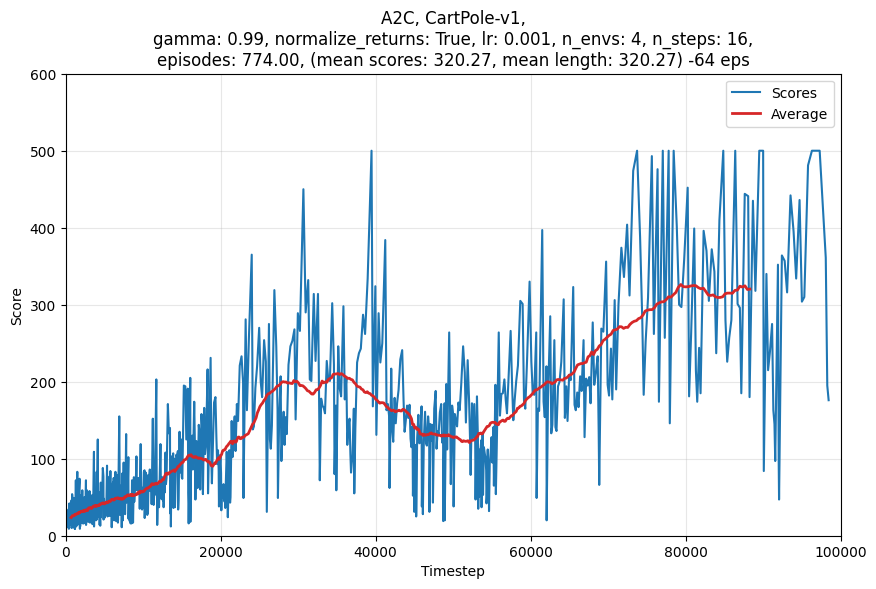

In [93]:
plot.plot_session(returns, lengths, 'A2C', env_name, n_timesteps, params=asdict(params))

you'll need a Modal account to run this next lot of code, which runs the same thing many times.

it's free to sign up and run code.

In [95]:
app = modal.App(name='rl')

image = modal.Image.debian_slim()\
    .apt_install('swig', 'build-essential')\
        .pip_install("gymnasium", "torch", "gymnasium[box2d]", "numpy", "stable_baselines3")\
        .add_local_python_source('session_tracker')

In [107]:
@app.function(image=image, timeout=3600)
def modal_train_a2c(env_name, n_timesteps, params=None):
    agent = ActorCriticAgent(state_space=gym.make(env_name).observation_space.shape[0],
                          action_space=gym.make(env_name).action_space.n)
    
    returns, lengths = train_a2c(
        agent, env_name, n_timesteps=n_timesteps, params=params)
    return returns, lengths

In [108]:
n_sessions = 16
env_name = 'LunarLander-v3'
n_timesteps = 400000
params = A2CParams(gamma=0.99, normalize_returns=True, lr=0.001, n_envs=4, n_steps=16)

with app.run():
    calls = [modal_train_a2c.spawn(
        env_name=env_name, n_timesteps=n_timesteps, params=params)
        for i in range(n_sessions)]

    results = modal.FunctionCall.gather(*calls)

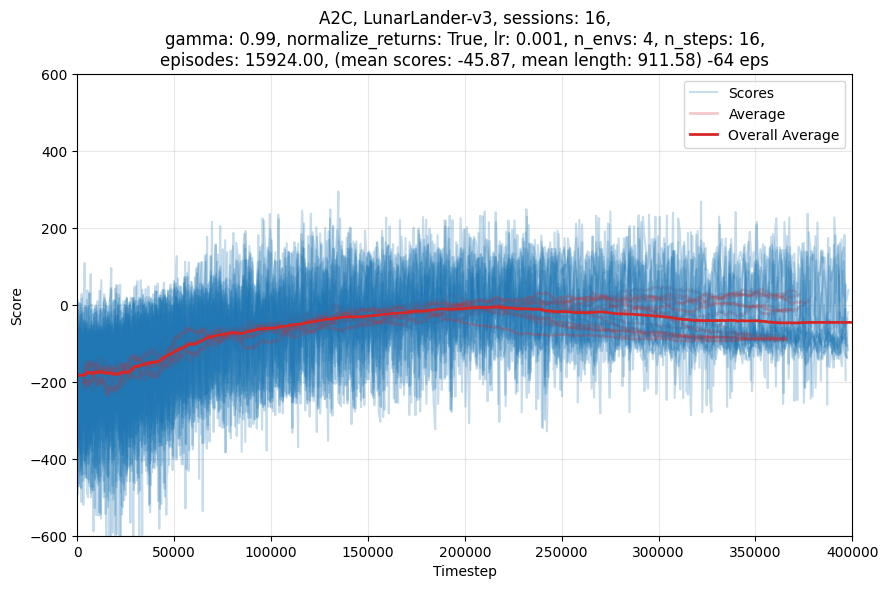

In [110]:
plot.plot_sessions(results, 'A2C', env_name, n_timesteps, params=asdict(params))